# Transformer from scratch

This notebook builds a simple Transformer from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in tensorflow.

It serves to demonstrate how each part of the Transformer works and how they all fit together.

The Transformer is then tested on a simple seq2seq task: translating sentences from English to French.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

**Steps :**
1. [Preparing the data](#Preparing-the-data)
2. [Building the Transformer](#Building-the-Transformer)
3. [Training the Transformer](#Training-the-Transformer)
4. [Testing the Transformer](#Testing-the-Transformer)
    
*[Credits and stuff](#Credits-and-stuff)*

In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.11.0

GPU is AVAILABLE


# Preparing the data

## Parsing the file

In [3]:
# parse the file
path = "/kaggle/input"
path = path if os.path.exists(path) else ".{}".format(path)

text_file = os.path.join(path, "fra-eng", "fra.txt")
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
data = []
for line in lines:
    english, french = line.split("\t")
    french = "[start] " + french + " [end]"
    data.append((english, french))

# display a few random samples just to get an idea of the data
for i in range(5):
    print(data[random.randint(0, len(data))])

('One more person will be joining us later.', '[start] Une personne de plus se joindra à nous plus tard. [end]')
('Are you talking to yourself again?', '[start] Converses-tu encore avec toi-même ? [end]')
('Tom was my role model.', '[start] Tom était mon modèle. [end]')
('It would take at least three hours to do that.', '[start] Ça prendrait au moins trois heures de faire ça. [end]')
('Where would you like to go next?', '[start] Où souhaiterais-tu aller ensuite ? [end]')


## Shuffling the data and splitting it into train, validation, and test sets:

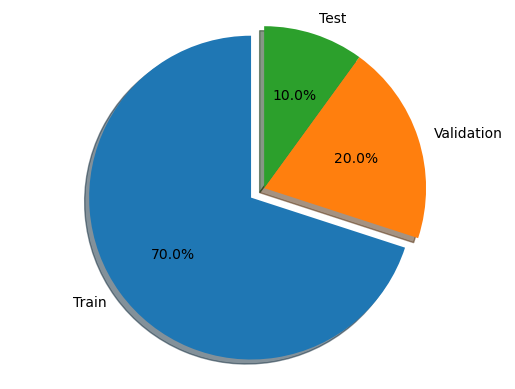

In [4]:
# shuffle the data
random.shuffle(data)

# split the data into train, validation, and test sets
train = data[:int(len(data)*0.7)]
validation = data[int(len(data)*0.7):int(len(data)*0.9)]
test = data[int(len(data)*0.9):]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train), len(validation), len(test)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

## Vectorizing the data

This step takes our raw text data and converts it in a format that can be used by our model.

To keep things simple, we will first limit our vocabulary using the **max_tokens** parameter. We will also limit the length of each sample using the **sequence_length** parameter.

Each sample (text input) will be standardize, tokenize by word, and then indexed by token.

This will result in a matrix of vectors (input IDs) of shape (batch_size, **sequence_length**).

In [5]:
max_tokens = 20000
sequence_length = 30

# convert to lowercase and strip all punctuations except "[" and "]", so we can tell apart the words "start" and "end" from the tokens "[start]" and "[end]"
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")
 
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)
train_source_texts = [text[0] for text in train]
train_target_texts = [text[1] for text in train]
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [6]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): I'm sorry, I didn't hear you.
Target texts (one random sample): [start] Je suis désolé, je ne t'ai pas entendue. [end]
Source vectors (one random sample): tf.Tensor(
[ 25 201   2  54 221   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2    4   26  297    4    8  309    6 2212    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): im sorry i didnt hear you                         
Target decoded texts (one random sample): [start] je suis désolé je ne tai pas entendue [end]                      


In [7]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (116990, 30)
Target vectors (shape): (116990, 31)


# Building the Transformer

## Embedding and Position Encoding

This step takes our matrix of vectors (input IDs) of shape (batch_size, sequence_length) and embeds it while adding positional information.

Each vector will be embedded in a low-dimensional floating-point vectors (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Each embedding vector will then be augmented with positional information.

This will result in a matrix of shape (batch_size, sequence_length, **embedding_size**).

In [8]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [9]:
# display the shape of our embedded data just to test the class

embed_dim = 256

train_source_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="source_embedding",
) (train_source_vectors)

train_target_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="target_embedding",
) (train_source_vectors)

print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (116990, 30, 256)
Target embedded vectors (shape): (116990, 30, 256)


## The Attention mechanism

A simple implementation of a Transformer's attention mechanism from scratch.

In practice, we could just use **tf.keras.layers.MultiHeadAttention** instead of building it from scratch. 😒

### Scaled Dot-Product Attention

The scaled dot product attention is calculated as follows :

***Attention(Q, K, V) = softmax(QK^T / √(d_k))V***

Where Q, K, V are the query, key, and value matrices and d_k is the dimensionality of the key matrix.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-19.png" width="100">](https://arxiv.org/abs/1706.03762)

In [10]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w
    
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    outputs = tf.matmul(weights, v) # Matmul of SoftMax and V
    return outputs

In [11]:
# display the shape of our attention output just to test the function
input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (116990, 1, 30, 256)


In [12]:
# display the masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 1.59944177e-01 -1.00000000e+10 -1.00000000e+10 -1.00000000e+10
    -1.00000000e+10]
   [ 1.98841095e-02  6.20521903e-01 -1.00000000e+10 -1.00000000e+10
    -1.00000000e+10]
   [ 8.04124475e-01  3.30407619e-02  3.17059875e-01 -1.00000000e+10
    -1.00000000e+10]
   [ 1.60982728e-01  1.24920964e-01  3.91911626e-01  2.50247002e-01
    -1.00000000e+10]
   [ 3.89785767e-02  9.60114241e-01  1.52646184e-01  7.21741796e-01
     9.14231658e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


### Multi-Head Attention

The multi-head attention is calculated as follows :

***MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O***

Where head_i is the i-th attention head, W^O is the output matrix, and **h** is the number of attention heads.
    
[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-20.png" width="200">](https://arxiv.org/abs/1706.03762)

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

## The Encoder

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_encoder-zoom.png" width="400">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)


In the Encoder's Multi-Head Self-Attention layer ([Global self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_global_self_attention_layer)), the **Source Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In [14]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

## The Decoder

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_decoder-zoom.png" width="500">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)


In the Decoder's Masked Multi-Head Self-Attention layer ([Causal self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_causal_self_attention_layer)), the **Target Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In the Decoder’s Encoder-Decoder Attention layer ([Cross attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_cross_attention_layer)), the **outputs of the Encoder** are being passed to the **K**ey and **V**alue parameters, with the **outputs of the Decoder's Masked Multi-Head Self-Attention layer** being passed to the **Q**uery parameter.

In [15]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.layer_norm_3 = tf.keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

## Putting it all together

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

We  turn our data into a tf.data pipeline. We want it to return a tuple (Inputs, Outputs) where Inputs is a dict with two keys, “encoder_inputs” (the source sequence) and “decoder_inputs” (the target sequence), and Outputs is a single key (the target sentence "shifted right").

The role of the decoder is to look at the target sequence so far and predicts the target sequence offset by one step ahead ("shifted right"). During inference, we generate one target token at a time and feed it back into the decoder.

In [16]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs (which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(texts):
    source_texts, target_texts = zip(*texts)
    source_texts = list(source_texts)
    target_texts = list(target_texts)
    dataset = tf.data.Dataset.from_tensor_slices((source_texts, target_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train)
validation_ds = make_dataset(validation)

In [17]:
#display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (64, 30)
Decoder Inputs: (64, 30)
Decoder Outputs: (64, 30)


[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_transformer-encoder-decoder.png" width="600">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)


In [18]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# transformer body
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# transformer head
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Training the Transformer

In [19]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=validation_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/50
1828/1828 [==============================] - 201s 105ms/step - loss: 0.9964 - accuracy: 0.8495 - val_loss: 0.6110 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 2/50
1828/1828 [==============================] - 177s 97ms/step - loss: 0.5747 - accuracy: 0.9002 - val_loss: 0.4923 - val_accuracy: 0.9102 - lr: 0.0010
Epoch 3/50
1828/1828 [==============================] - 176s 96ms/step - loss: 0.4704 - accuracy: 0.9127 - val_loss: 0.4513 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 4/50
1828/1828 [==============================] - 175s 96ms/step - loss: 0.4095 - accuracy: 0.9206 - val_loss: 0.4314 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 5/50
1828/1828 [==============================] - 175s 96ms/step - loss: 0.3665 - accuracy: 0.9267 - val_loss: 0.4260 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 6/50
1828/1828 [==============================] - 175s 96ms/step - loss: 0.3324 - accuracy: 0.9320 - val_loss: 0.4171 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 7/50
1828/1828 [=================

# Testing the Transformer

Let's translate a few random test sentences with our trained Transformer.

In [20]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_source_texts = [text[0] for text in test]

# let's translate 50 random sentences
for _ in range(50):
    input_sentence = random.choice(test_source_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom and Mary were both alcoholics.
[start] tom et mary étaient tous les deux [UNK] [end]
-
I don't need a doctor.
[start] je nai pas besoin dun médecin [end]
-
They missed the deadline.
[start] ils ont loupé la date limite [end]
-
I'll be there in five minutes.
[start] je serai là dans cinq minutes [end]
-
I was surprised by what I learned.
[start] jai été surpris par ce que jai appris [end]
-
You're not allowed to eat those.
[start] vous nêtes pas autorisée à manger ceuxlà [end]
-
You have only to push this button.
[start] tu nas que pour pousser sur ce bouton [end]
-
You don't kick a man when he's down.
[start] tu [UNK] pas un homme quand il est en panne [end]
-
He has a big truck.
[start] il a un grand camion [end]
-
This job has no future.
[start] ce boulot na pas de futur [end]
-
There's no more ointment.
[start] il ny a pas plus de [UNK] [end]
-
Don't read in this room.
[start] ne lis pas dans cette pièce [end]
-
Tell Tom I'll be back.
[start] dis à tom que je serai de retour [

# Credits and stuff

- https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11

- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb

- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/ch03.html

- https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb

- https://arxiv.org/abs/1706.03762

- https://www.tensorflow.org/text/tutorials/transformer

- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

- https://github.com/openai/gpt-2/blob/master/src/model.py

